In [1]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, precision_score, f1_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
import joblib
import shap
sns.set()

In [3]:
raw_data = pd.read_csv('dataset.csv')
raw_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
raw_data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
raw_data.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


### Univariate analysis

*Analysis of target variable isFraud*

In [5]:
raw_data['isFraud'].isna().sum()

0

In [6]:
#nr of unique values
raw_data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [7]:
#percentage of values frequency
raw_data['isFraud'].value_counts()/len(raw_data)*100

isFraud
0    99.870918
1     0.129082
Name: count, dtype: float64

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\4146260025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=raw_data, x='isFraud', palette='Set2')


Text(0.5, 1.0, 'Distribution of target variable (logarithmic)')

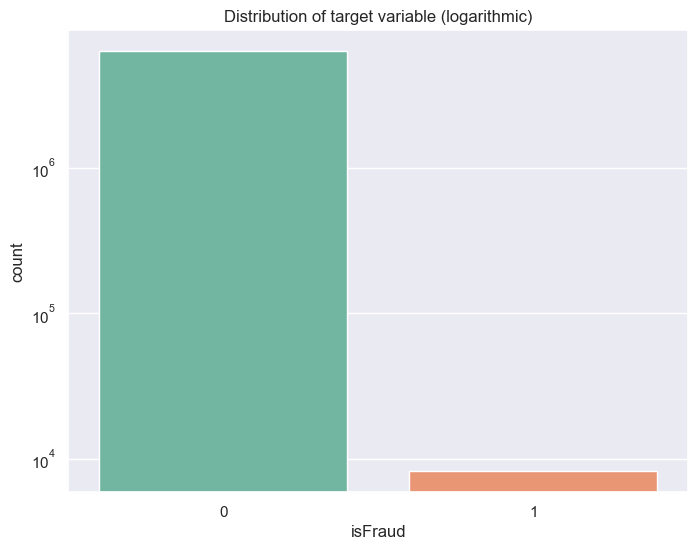

In [9]:
#Distribution of target variable

fig,ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(data=raw_data, x='isFraud', palette='Set2')
ax.set_yscale('log')
ax.set_title('Distribution of target variable (logarithmic)')


### Explore categorical variables

In [8]:
raw_data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [9]:
categorical_columns = [col for col in raw_data.columns if raw_data[col].dtypes=='object']

In [10]:
raw_data[categorical_columns].head(5)

,type,nameOrig,nameDest
0,PAYMENT,C1231006815,M1979787155
1,PAYMENT,C1666544295,M2044282225
2,TRANSFER,C1305486145,C553264065
3,CASH_OUT,C840083671,C38997010
4,PAYMENT,C2048537720,M1230701703


In [11]:
raw_data[categorical_columns].describe()

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1677795071,C1286084959
freq,2237500,3,113


Since there are over 6 million types of nameOrig and over 2 millions for nameDest, I will remove these 2 categorical variables since they do not provide many information and will need a lot of dummies.

### Feature engineering of categorical columns

In [6]:
#Create a variable to identify if the nameDest is merchant or customer

data_preprocessed = raw_data.copy()
data_preprocessed['receiverType'] = data_preprocessed['nameDest'].str[0]
data_preprocessed['receiverType']

0          M
1          M
2          C
3          C
4          M
          ..
6362615    C
6362616    C
6362617    C
6362618    C
6362619    C
Name: receiverType, Length: 6362620, dtype: object

In [7]:
data_preprocessed['receiverType'] = data_preprocessed['receiverType'].map({'M':'Merchant', 'C':'Customer'})
data_preprocessed['receiverType']

0          Merchant
1          Merchant
2          Customer
3          Customer
4          Merchant
             ...   
6362615    Customer
6362616    Customer
6362617    Customer
6362618    Customer
6362619    Customer
Name: receiverType, Length: 6362620, dtype: object

### Distribution of the categorical variables

In [8]:
categorical_columns = ['type','receiverType']

C:\Users\mihai\AppData\Local\Temp\ipykernel_3536\2110455663.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


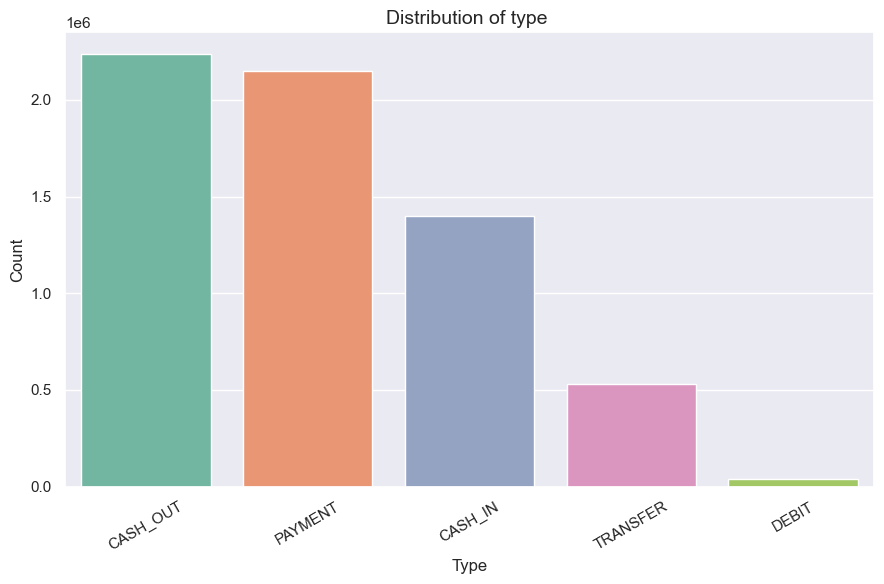

C:\Users\mihai\AppData\Local\Temp\ipykernel_3536\2110455663.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


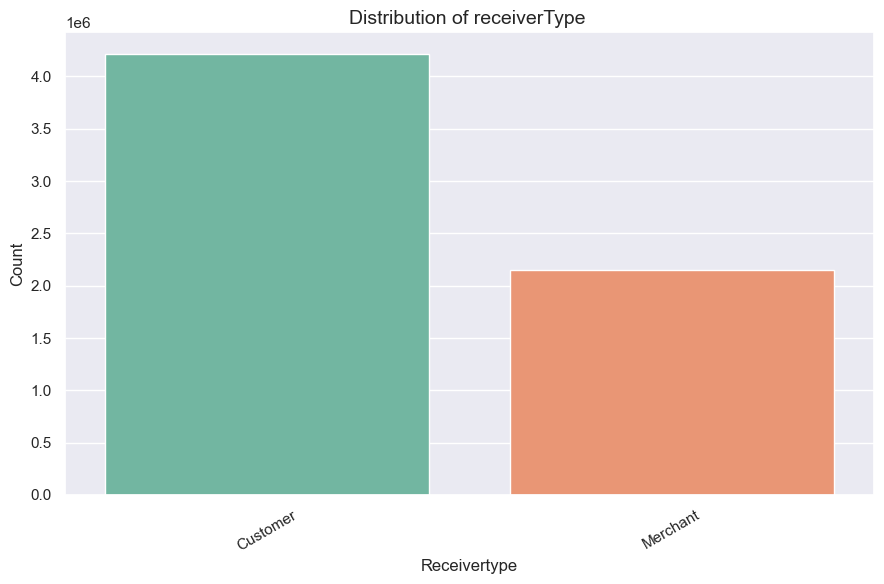

In [7]:
for col in categorical_columns:
    fig, ax = plt.subplots(figsize=(9,6))
    
    sns.countplot(
        data=data_preprocessed,
        x=col,
        palette='Set2',
        ax=ax,
        order=data_preprocessed[col].value_counts().index
    )
    
    ax.set_title(f'Distribution of {col} ', fontsize=14)
    ax.set_xlabel(col.capitalize(), fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=30)    
    plt.tight_layout()
    plt.show()


### Distribution of the categorical variables based on target

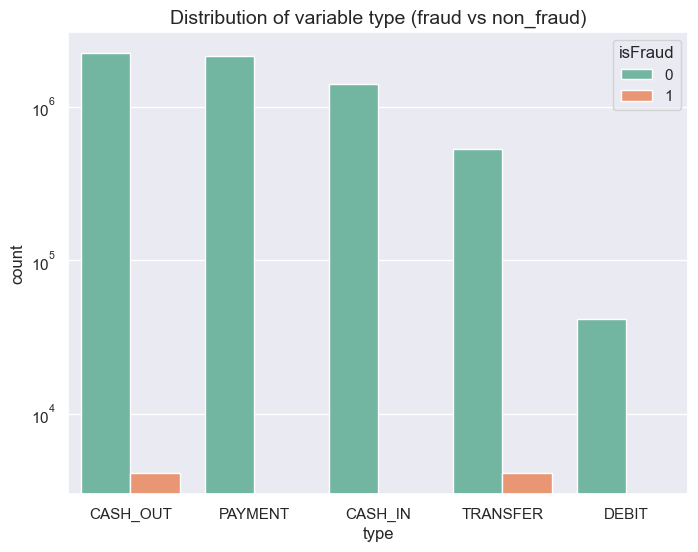

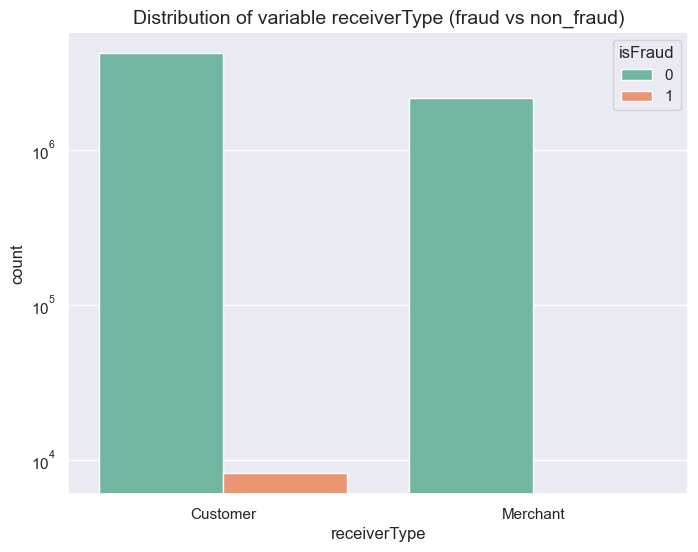

In [25]:
for col in categorical_columns:
    fig,ax = plt.subplots(figsize=(8,6))
    ax=sns.countplot(data=data_preprocessed, x=col, hue='isFraud', palette='Set2', order=data_preprocessed[col].value_counts().index)
    ax.set_yscale('log')
    ax.set_title(f'Distribution of variable {col} (fraud vs non_fraud)', fontsize=14)
    plt.show()     

### Missing values

In [9]:
data_preprocessed[categorical_columns].isnull().sum()

type            0
receiverType    0
dtype: int64

### Explore numerical variables

In [8]:
numerical_columns=[col for col in data_preprocessed.columns if data_preprocessed[col].dtypes!="object" and col!='isFraud']

In [9]:
data_preprocessed[numerical_columns].head(5)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,181.00,181.0,0.00,0.0,0.0,0
3,1,181.00,181.0,0.00,21182.0,0.0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0


### Distribution of numerical columns

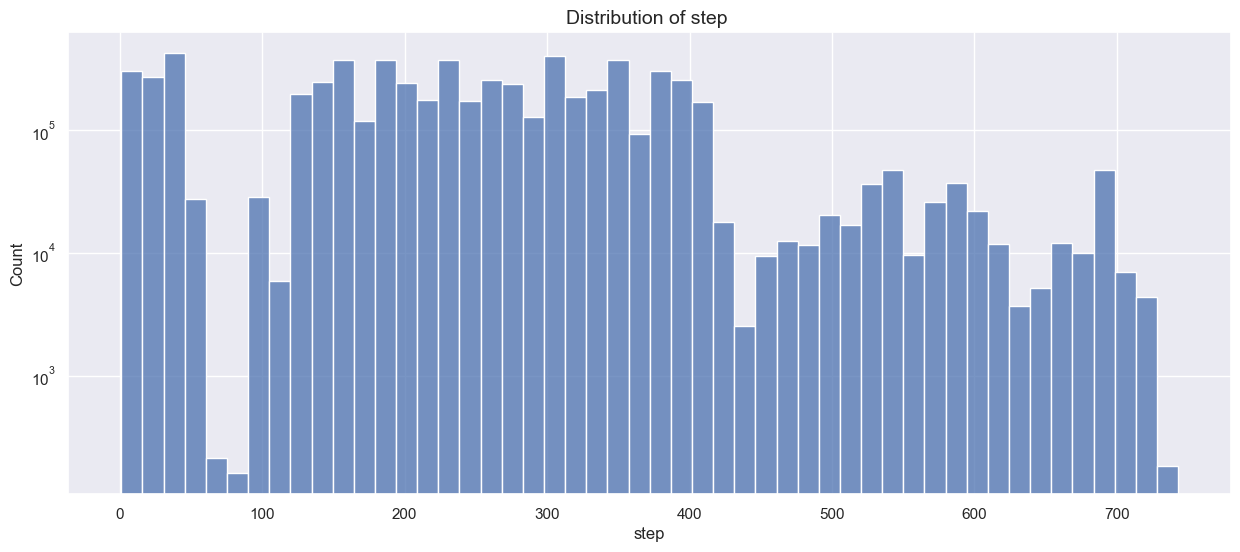

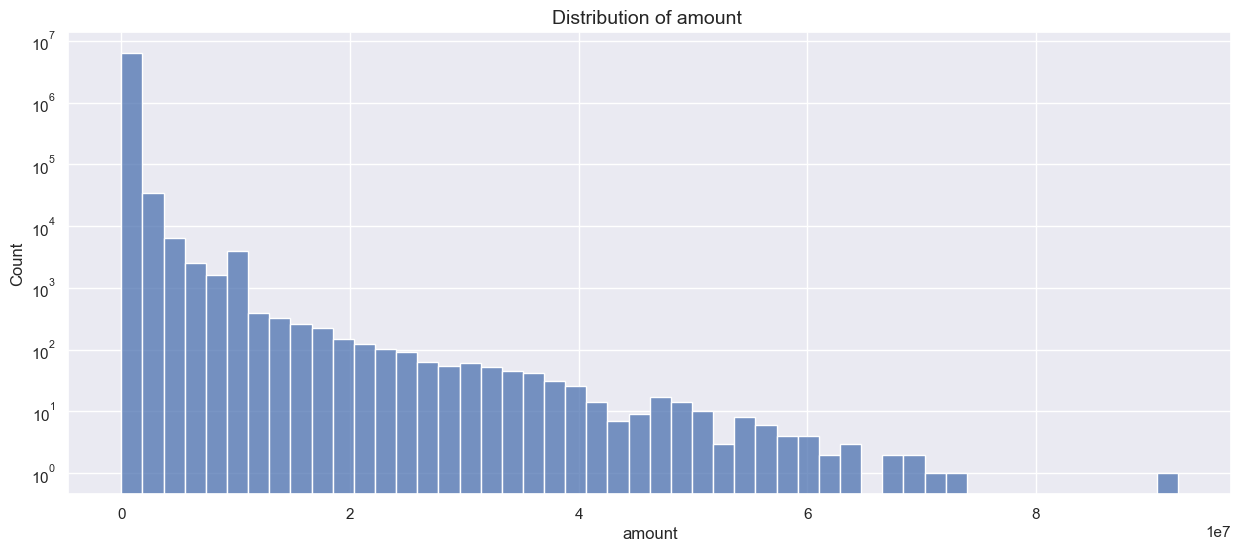

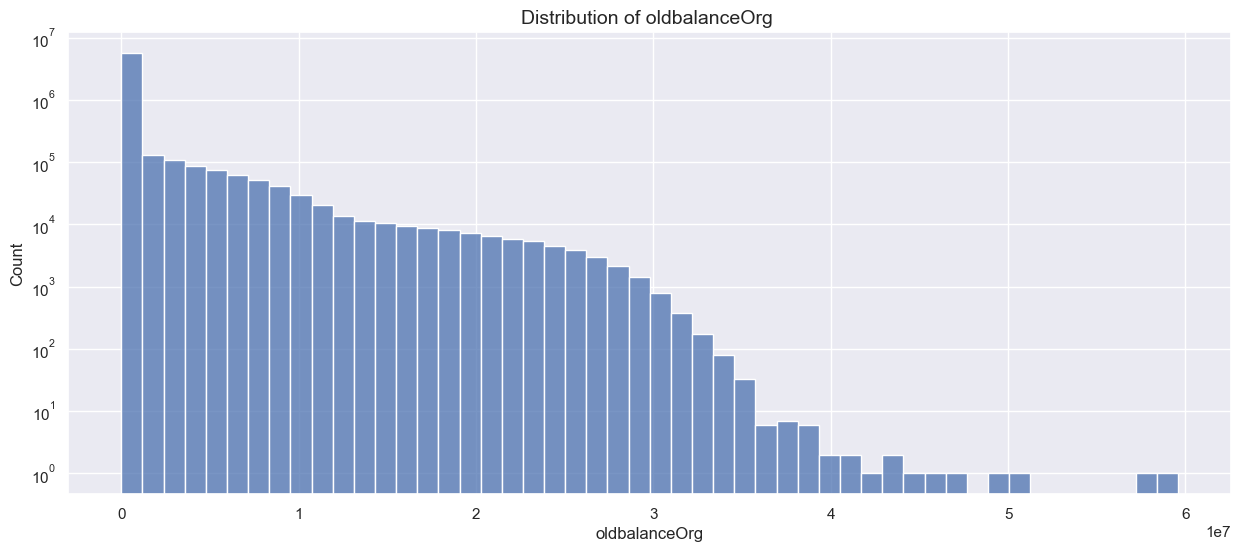

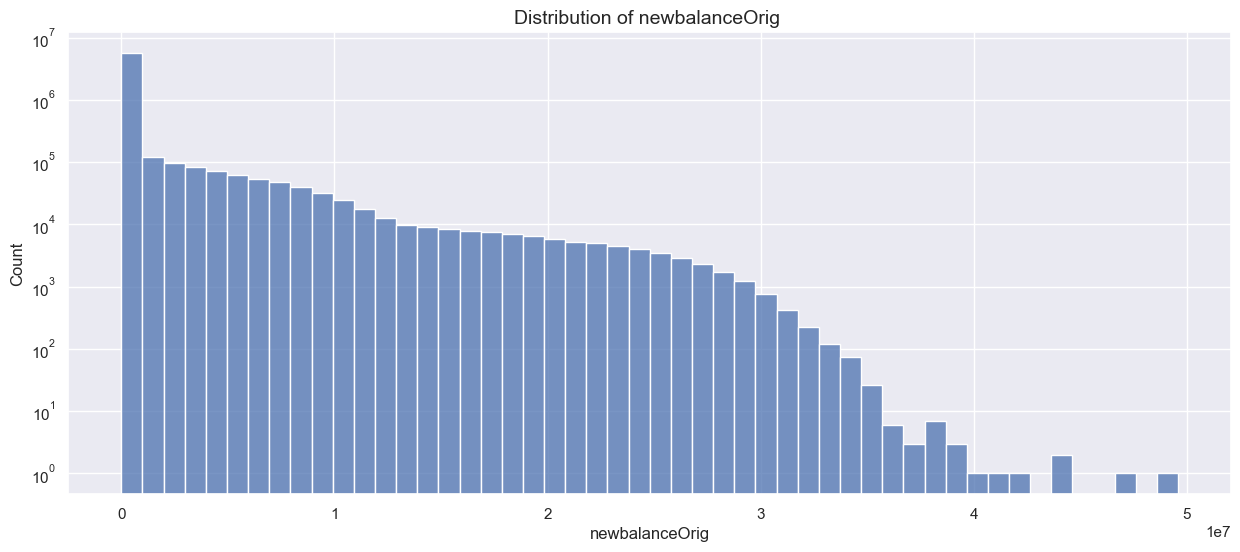

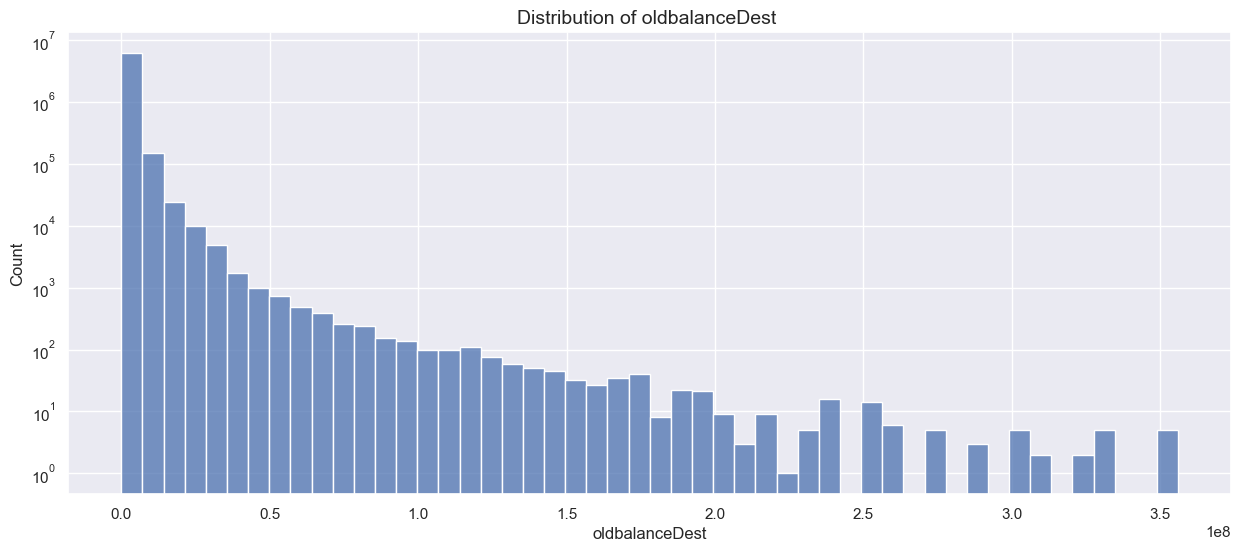

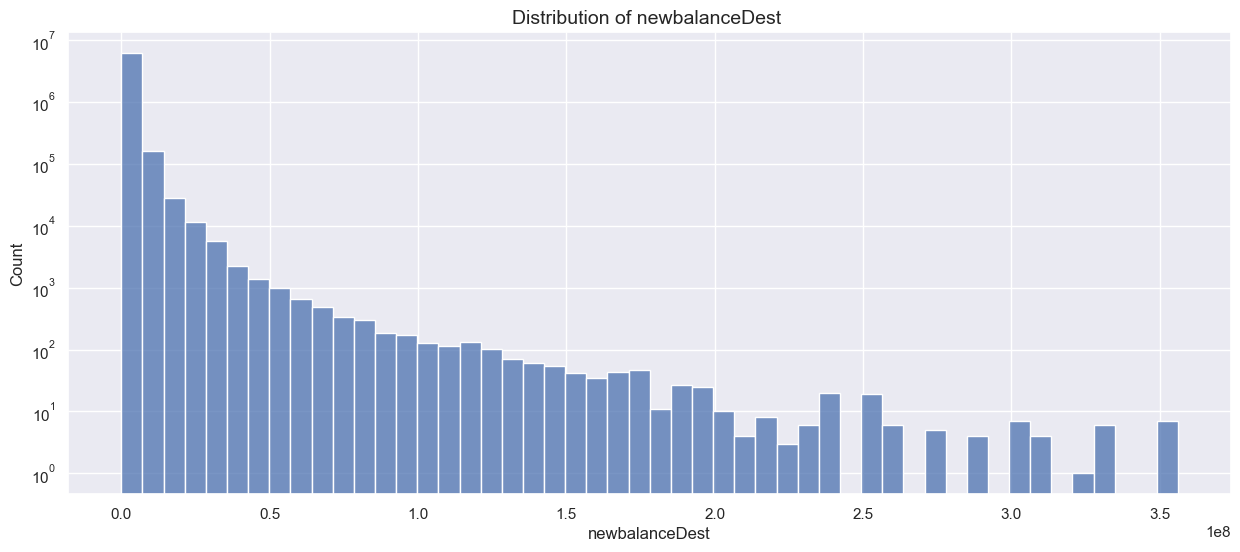

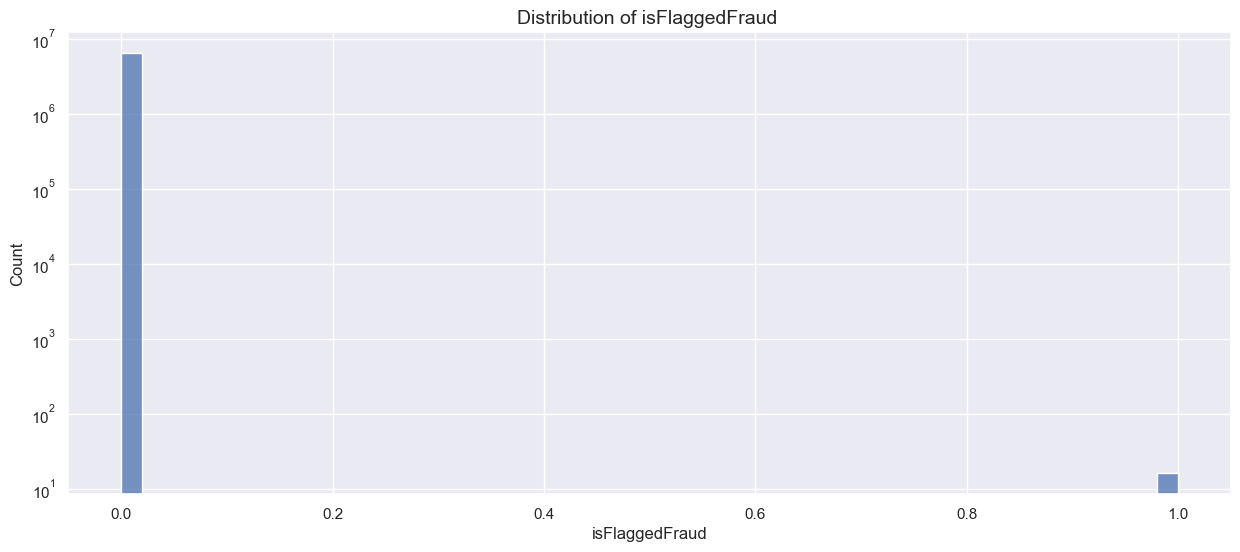

In [23]:
for col in numerical_columns:
    fig,ax=plt.subplots(figsize=(15,6))
    sns.histplot(data_preprocessed[col],bins=50)
    ax.set_yscale('log')
    ax.set_title(f'Distribution of {col} ', fontsize=14)
    plt.show()

### Missing values

In [10]:
data_preprocessed[numerical_columns].isna().sum()

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64

### Outliers detection

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\534924791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)


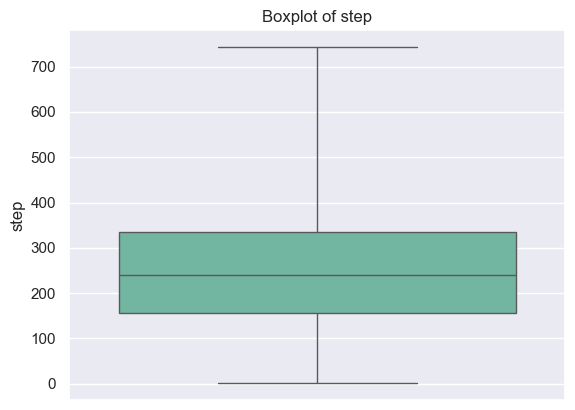

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\534924791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)


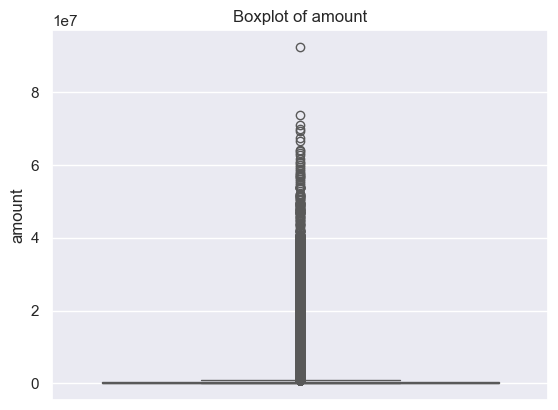

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\534924791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)


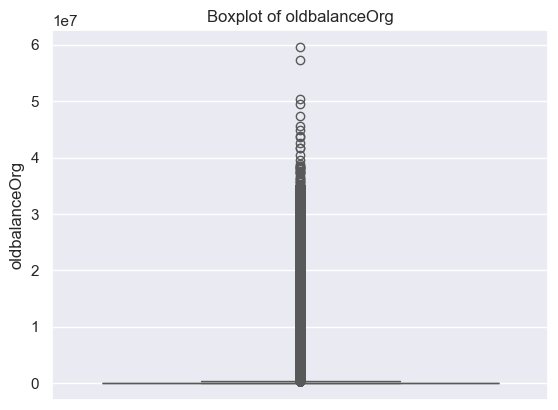

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\534924791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)


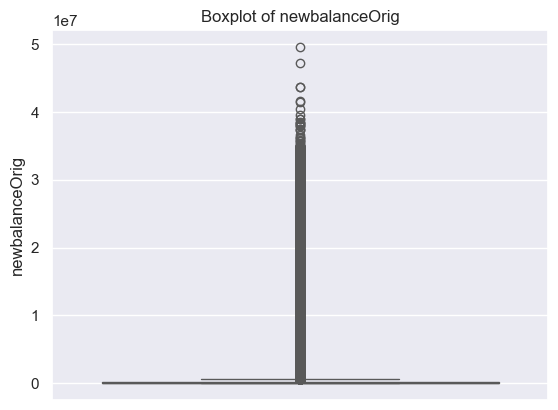

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\534924791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)


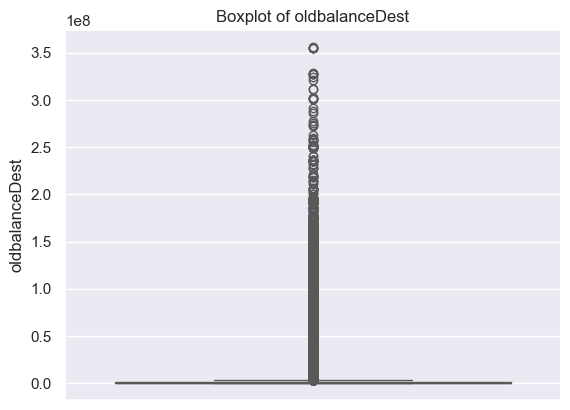

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\534924791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)


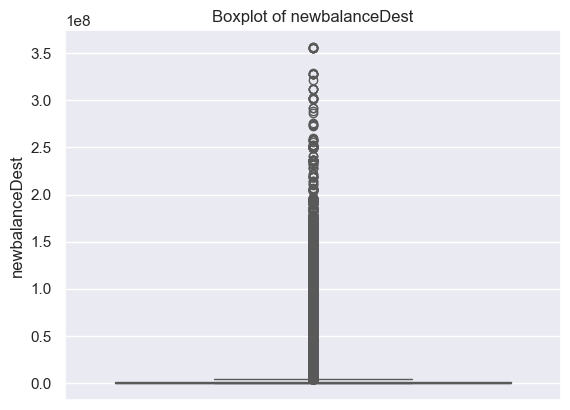

C:\Users\mihai\AppData\Local\Temp\ipykernel_22732\534924791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)


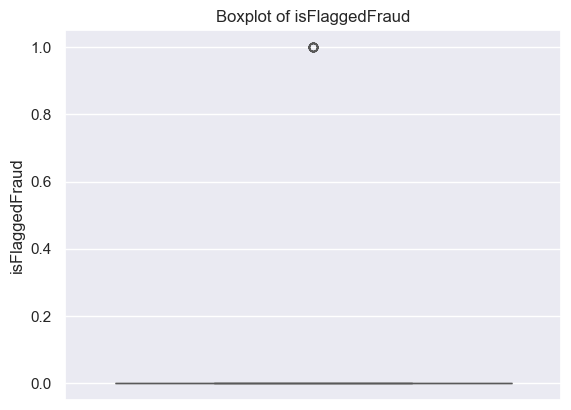

In [27]:
#Outliers detection

for col in numerical_columns:
    fig,ax = plt.subplots=(15,16)
    sns.boxplot(data=data_preprocessed[col], palette='Set2', whis=3)
    plt.title(f"Boxplot of {col}")
    plt.show()

In [21]:
affected_by_outliers = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

In [22]:
#create a function to remove outliers

def remove_outliers_iqr(df, column, k=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

In [23]:
data_no_outliers = data_preprocessed.copy()

for col in affected_by_outliers:
    data_no_outliers = remove_outliers_iqr(data_no_outliers, col, k=1.5)

*Before removing outliers*

In [24]:
data_preprocessed['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

*After removing outliers*

In [25]:
data_no_outliers['isFraud'].value_counts()

isFraud
0    3248382
1       3027
Name: count, dtype: int64

*After removing outliers using the IQR method, more than 60% of fraudulent transactions were eliminated, confirming that fraud cases are predominantly located in the extreme values of numerical features. Therefore, outliers were retained in the final dataset to avoid significant information loss.*

### Feature engineering for numerical variables

In [11]:
data_preprocessed[numerical_columns].head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,181.00,181.0,0.00,0.0,0.0,0
3,1,181.00,181.0,0.00,21182.0,0.0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0


In [9]:
data_preprocessed['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

*This variable identified only 16 possible fraudulent transactions, therefore this variable will be removed since it does not provide any usefull information*

In [10]:
data_preprocessed = data_preprocessed.drop(['isFlaggedFraud'], axis=1)

In [11]:
numerical_columns = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

### Correlation for numerical variables

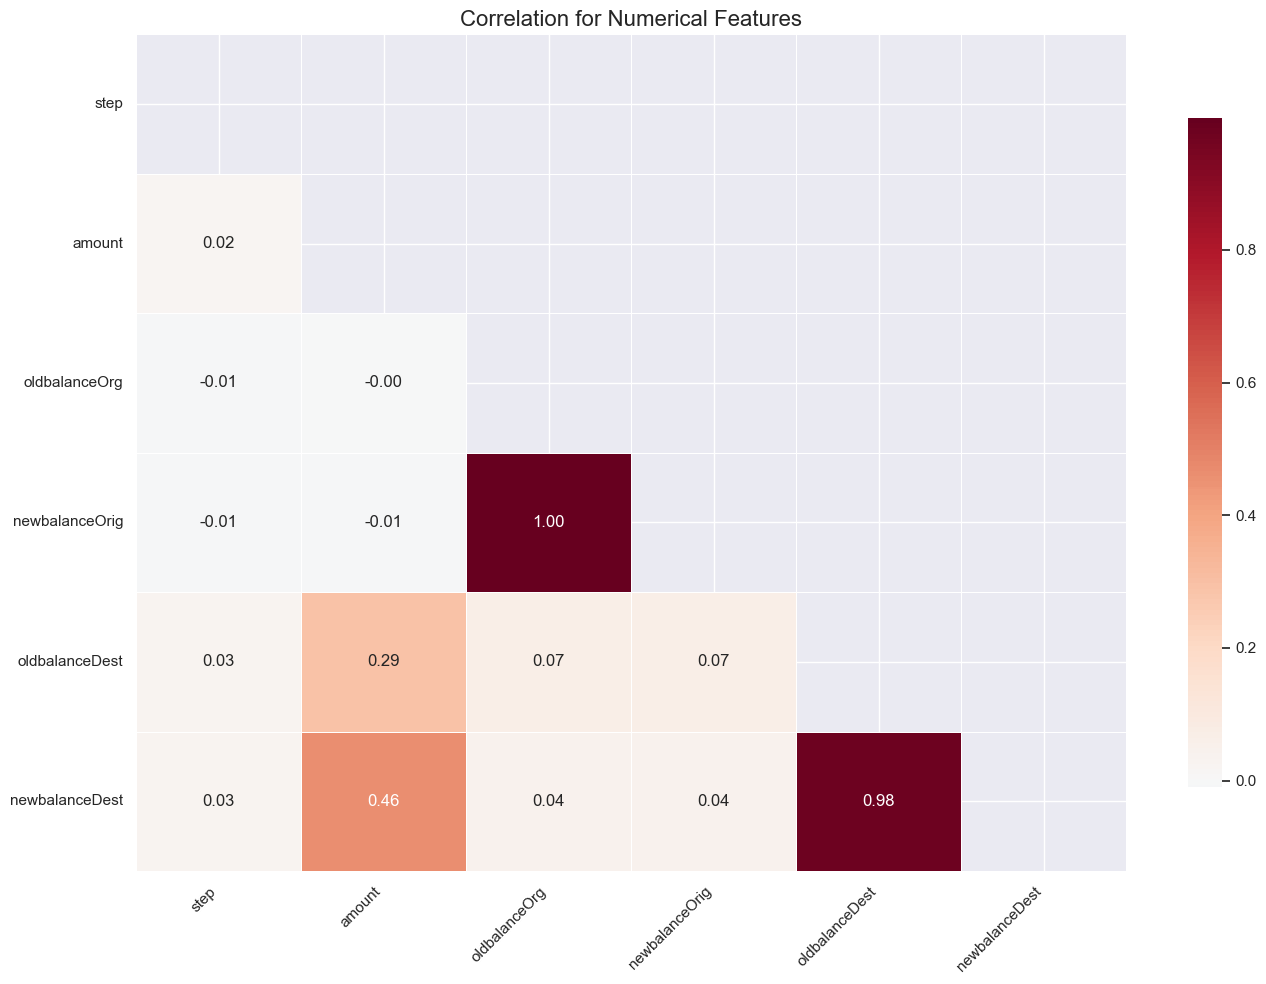

In [37]:
corr = data_preprocessed[numerical_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14,10))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=True, fmt='.2f', linewidths=0.5, linecolor='white', cbar_kws={'shrink': 0.8}
)

plt.title('Correlation for Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

*Since the balances are highly correlated, we will create two variables to show the difference between the new balance and old balance of sender and receiver*

In [12]:
#create a new dataframe for fe(feature engineering)

data_fe = data_preprocessed.copy()

In [13]:
data_fe['balanceSender'] = (data_fe['oldbalanceOrg'] - data_fe['newbalanceOrig'])

In [14]:
data_fe[['balanceSender','amount']]

,balanceSender,amount
0,9839.64,9839.64
1,1864.28,1864.28
2,181.00,181.00
3,181.00,181.00
4,11668.14,11668.14
...,...,...
6362615,339682.13,339682.13
6362616,6311409.28,6311409.28
6362617,6311409.28,6311409.28
6362618,850002.52,850002.52


In [15]:
#create a variable to show the difference between amount and the balance of the sender

data_fe['senderMismatch'] = (
    ~np.isclose(
        data_fe['balanceSender'],
        data_fe['amount'],
        atol=0.01
    )
).astype(int)

In [16]:
data_fe['balanceReceiver'] = (data_fe['newbalanceDest'] - data_fe['oldbalanceDest'])

In [17]:
data_fe[['balanceReceiver','amount']]

,balanceReceiver,amount
0,0.00,9839.64
1,0.00,1864.28
2,0.00,181.00
3,-21182.00,181.00
4,0.00,11668.14
...,...,...
6362615,339682.13,339682.13
6362616,0.00,6311409.28
6362617,6311409.27,6311409.28
6362618,0.00,850002.52


In [18]:
#create a variable to show the difference between amount and the balance of the receiver

data_fe['receiverMismatch'] = (
    ~np.isclose(
        data_fe['balanceReceiver'],
        data_fe['amount'],
        atol=0.01
    )
).astype(int)

### Create two new time variables based on the step

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

In [19]:
data_fe['hourOfDay'] = data_fe['step'] % 24
data_fe['isNight'] = data_fe['hourOfDay'].between(0,5).astype(int)

### Distribution of fraud rate by hour of the day

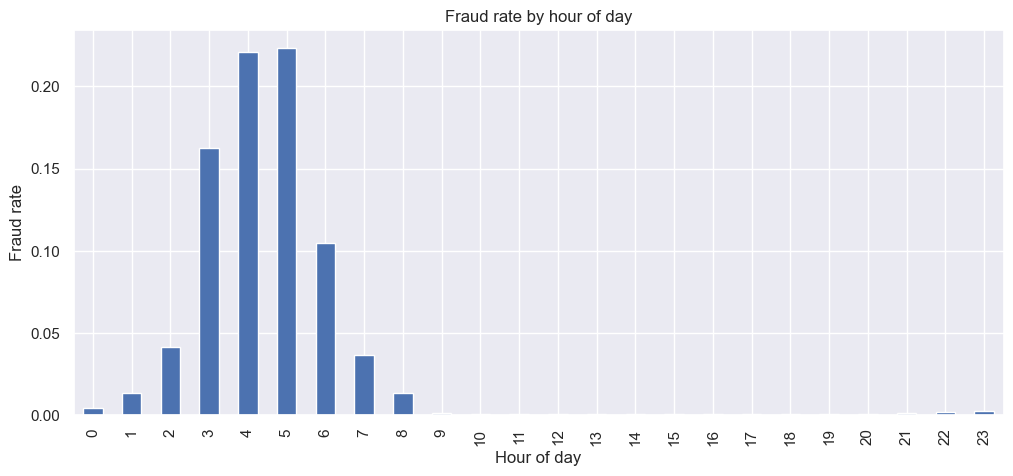

In [20]:
fraud_rate_by_hour = (
    data_fe.groupby('hourOfDay')['isFraud'].mean())

plt.figure(figsize=(12,5))
fraud_rate_by_hour.plot(kind='bar')
plt.title('Fraud rate by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Fraud rate')
plt.show()

C:\Users\mihai\AppData\Local\Temp\ipykernel_3536\552904647.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\mihai\AppData\Local\Temp\ipykernel_3536\552904647.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Day', 'Night'])


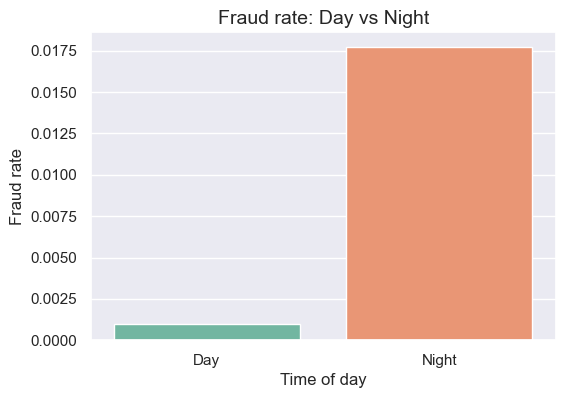

In [23]:
plt.figure(figsize=(6,4))

ax = sns.barplot(
    data=data_fe,
    x='isNight',
    y='isFraud',
    palette='Set2',
    errorbar=None
)

ax.set_title('Fraud rate: Day vs Night', fontsize=14)
ax.set_xlabel('Time of day', fontsize=12)
ax.set_ylabel('Fraud rate', fontsize=12)
ax.set_xticklabels(['Day', 'Night'])
plt.show()


In [21]:
data_fe.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,receiverType,balanceSender,senderMismatch,balanceReceiver,receiverMismatch,hourOfDay,isNight
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,Merchant,9839.64,0,0.0,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,Merchant,1864.28,0,0.0,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,Customer,181.00,0,0.0,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,Customer,181.00,0,-21182.0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,Merchant,11668.14,0,0.0,1,1,1


In [25]:
data_fe.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'receiverType', 'balanceSender', 'senderMismatch', 'balanceReceiver',
       'receiverMismatch', 'hourOfDay', 'isNight'],
      dtype='object')

In [26]:
numerical_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
       'balanceSender', 'senderMismatch', 'balanceReceiver',
       'receiverMismatch', 'hourOfDay', 'isNight']

### Correlation matrix for all the numerical variables

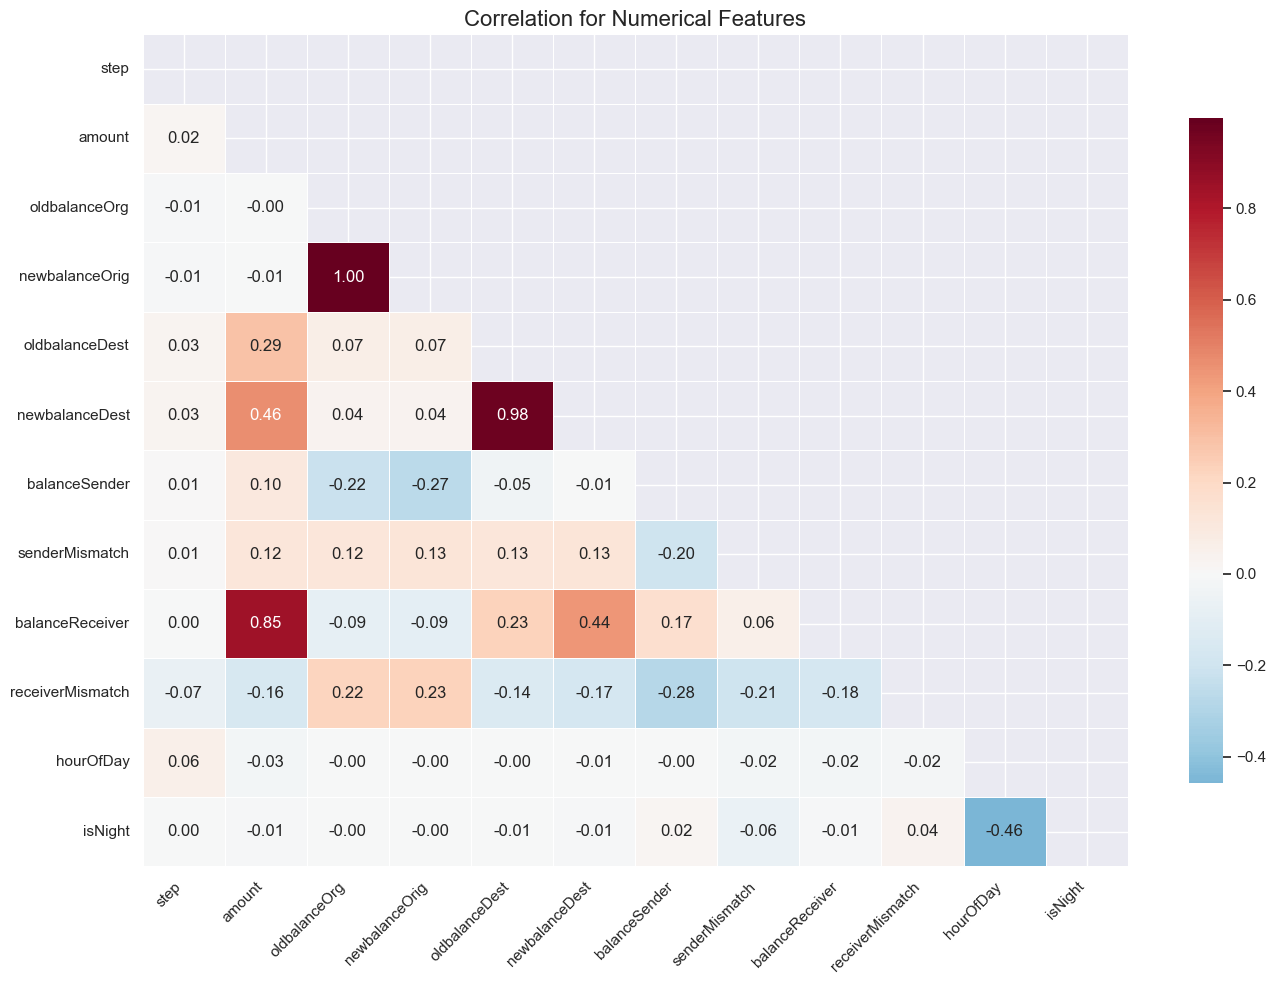

In [28]:
corr = data_fe[numerical_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14,10))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=True, fmt='.2f', linewidths=0.5, linecolor='white', cbar_kws={'shrink': 0.8}
)

plt.title('Correlation for Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Final preprocessed dataset

*Delete columns with correlation too high( newbalanceOrig, newbalanceDest, balanceReceiver) and the categorical columns with too many unique values(nameOrig,nameDest)*

In [22]:
data_fe.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,receiverType,balanceSender,senderMismatch,balanceReceiver,receiverMismatch,hourOfDay,isNight
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,Merchant,9839.64,0,0.0,1,1,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,Merchant,1864.28,0,0.0,1,1,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,Customer,181.00,0,0.0,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,Customer,181.00,0,-21182.0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,Merchant,11668.14,0,0.0,1,1,1


In [23]:
data_final = data_fe.drop(['step','nameOrig','nameDest','newbalanceOrig','balanceReceiver','balanceSender','newbalanceDest','hourOfDay'], axis=1)
data_final.head()

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,receiverType,senderMismatch,receiverMismatch,isNight
0,PAYMENT,9839.64,170136.0,0.0,0,Merchant,0,1,1
1,PAYMENT,1864.28,21249.0,0.0,0,Merchant,0,1,1
2,TRANSFER,181.00,181.0,0.0,1,Customer,0,1,1
3,CASH_OUT,181.00,181.0,21182.0,1,Customer,0,1,1
4,PAYMENT,11668.14,41554.0,0.0,0,Merchant,0,1,1


### Correlation for the final dataset

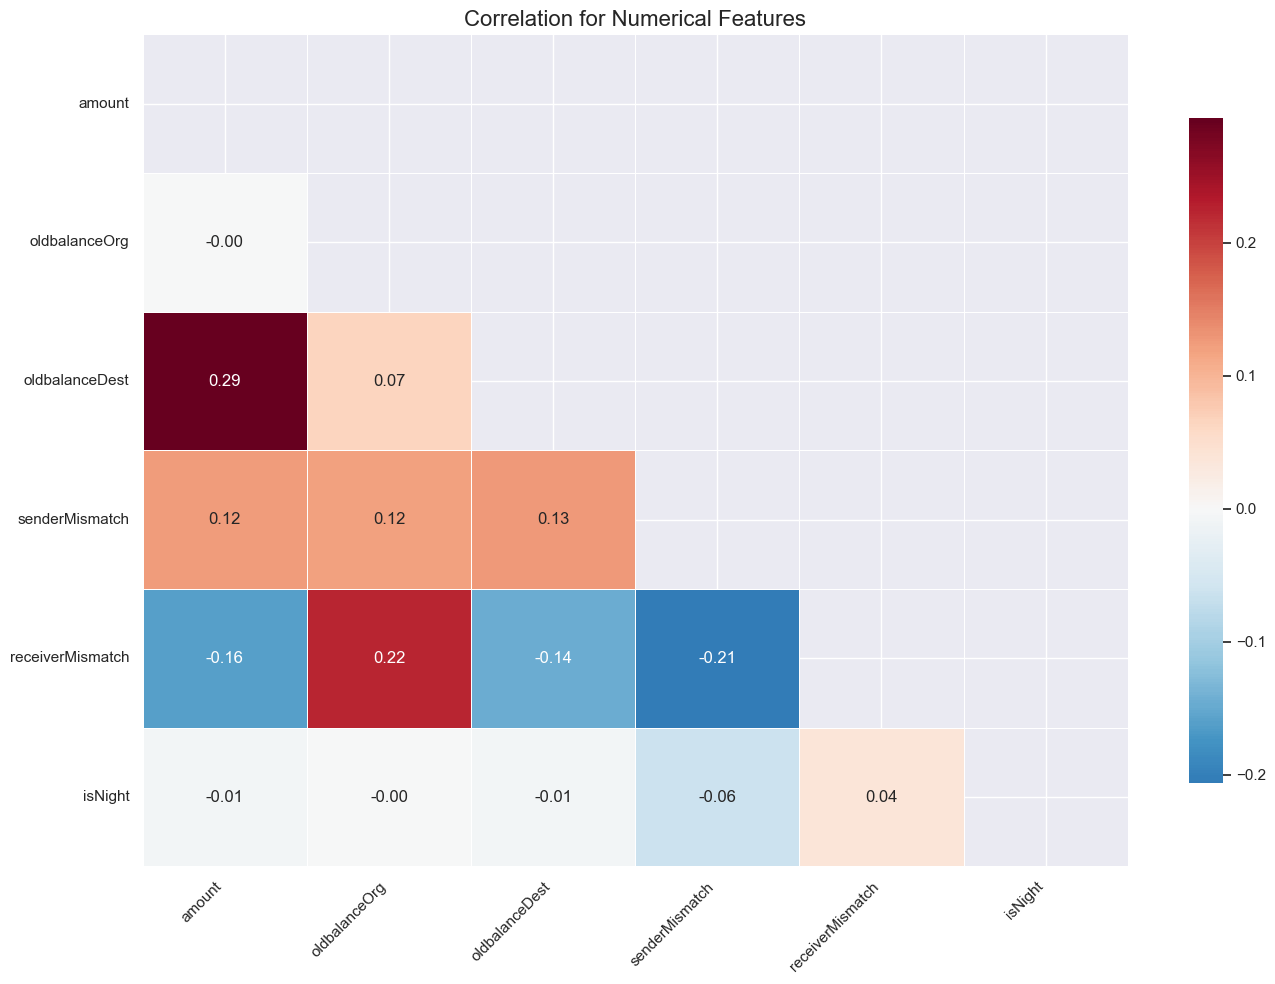

In [43]:
#corr = data_final[['amount','oldbalanceOrg','oldbalanceDest','balanceSender','senderMismatch','receiverMismatch','hourOfDay','isNight']].corr()
corr = data_final[['amount','oldbalanceOrg','oldbalanceDest','senderMismatch','receiverMismatch','isNight']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14,10))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, annot=True, fmt='.2f', linewidths=0.5, linecolor='white', cbar_kws={'shrink': 0.8}
)

plt.title('Correlation for Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


*There are no strong correlations, we can use all the variables as features for our models*

In [24]:
#shuffle the data

shuffled_data=data_final.sample(frac=1, random_state=1)
shuffled_data

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud,receiverType,senderMismatch,receiverMismatch,isNight
6322570,CASH_IN,23557.12,8059.00,169508.66,0,Customer,1,1,0
3621196,PAYMENT,6236.13,0.00,0.00,0,Merchant,1,1,0
1226256,PAYMENT,33981.87,18745.72,0.00,0,Merchant,1,1,0
2803274,CASH_OUT,263006.42,20072.00,390253.56,0,Customer,1,0,0
3201247,CASH_OUT,152013.74,20765.00,252719.19,0,Customer,1,0,0
...,...,...,...,...,...,...,...,...,...
5030793,CASH_OUT,156973.09,257335.00,6697137.26,0,Customer,0,0,0
491263,CASH_OUT,140745.33,0.00,1880641.65,0,Customer,1,0,0
3937352,CASH_OUT,128095.40,0.00,8557281.75,0,Customer,1,0,0
4686059,PAYMENT,5504.70,0.00,0.00,0,Merchant,1,1,0


In [25]:
#Declare the independent variables and the target

y = shuffled_data['isFraud']
x = shuffled_data.drop(columns=['isFraud'])

x.shape, y.shape

((6362620, 8), (6362620,))

In [31]:
x.head()

,type,amount,oldbalanceOrg,oldbalanceDest,receiverType,senderMismatch,receiverMismatch,isNight
6322570,CASH_IN,23557.12,8059.00,169508.66,Customer,1,1,0
3621196,PAYMENT,6236.13,0.00,0.00,Merchant,1,1,0
1226256,PAYMENT,33981.87,18745.72,0.00,Merchant,1,1,0
2803274,CASH_OUT,263006.42,20072.00,390253.56,Customer,1,0,0
3201247,CASH_OUT,152013.74,20765.00,252719.19,Customer,1,0,0


### Perform data preprocessing

In [26]:
cat_col = ['type','receiverType']

In [27]:
x=pd.get_dummies(x, columns=cat_col, drop_first=True)

In [28]:
x.head()

,amount,oldbalanceOrg,oldbalanceDest,senderMismatch,receiverMismatch,isNight,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,receiverType_Merchant
6322570,23557.12,8059.00,169508.66,1,1,0,False,False,False,False,False
3621196,6236.13,0.00,0.00,1,1,0,False,False,True,False,True
1226256,33981.87,18745.72,0.00,1,1,0,False,False,True,False,True
2803274,263006.42,20072.00,390253.56,1,0,0,True,False,False,False,False
3201247,152013.74,20765.00,252719.19,1,0,0,True,False,False,False,False


### Train test split

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print(f'Train set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}')

Train set: (5090096, 11), Validation set: (636262, 11), Test set: (636262, 11)


### Standardize numerical variables

In [30]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

numeric_columns = ['amount','oldbalanceOrg','oldbalanceDest']

x_train[numeric_columns] = scaler.fit_transform(x_train[numeric_columns])
x_val[numeric_columns] = scaler.transform(x_val[numeric_columns])
x_test[numeric_columns] = scaler.transform(x_test[numeric_columns])

### Models

### Base model - Logistic Regression

In [52]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [53]:
print('The Logistic Regression score is: ',lr_model.score(x_val, y_val))

The Logistic Regression score is:  0.9990208436147373


In [54]:
from sklearn.metrics import classification_report

y_pred_lr = lr_model.predict(x_val)

print("\nClassification report:\n", classification_report(y_val, y_pred_lr,target_names=['Not fraud', 'Fraud']))


Classification report:
               precision    recall  f1-score   support

   Not fraud       1.00      1.00      1.00    635441
       Fraud       0.81      0.31      0.45       821

    accuracy                           1.00    636262
   macro avg       0.91      0.66      0.73    636262
weighted avg       1.00      1.00      1.00    636262



In [ ]:
#save the model
joblib.dump(lr_model, "logistic_regression.pkl")

['logistic_regression.pkl']

### Random Forest

In [104]:
#Random Forest model

rf_model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=1)
rf_model.fit(x_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [105]:
y_pred_rf = rf_model.predict(x_val)

In [107]:
print("\nClassification report (Random Forest):\n",
      classification_report(y_val, y_pred_rf, target_names=['Not fraud', 'Fraud']))


Classification report (Random Forest):
               precision    recall  f1-score   support

   Not fraud       1.00      1.00      1.00    635441
       Fraud       0.97      0.83      0.89       821

    accuracy                           1.00    636262
   macro avg       0.99      0.91      0.95    636262
weighted avg       1.00      1.00      1.00    636262



In [108]:
y_pred_rf_test = rf_model.predict(x_test)
print("\nClassification report (Random Forest) on test:\n",
      classification_report(y_test, y_pred_rf_test, target_names=['Not fraud', 'Fraud']))


Classification report (Random Forest) on test:
               precision    recall  f1-score   support

   Not fraud       1.00      1.00      1.00    635440
       Fraud       0.97      0.83      0.89       822

    accuracy                           1.00    636262
   macro avg       0.98      0.91      0.95    636262
weighted avg       1.00      1.00      1.00    636262



In [ ]:
#save the model

joblib.dump(rf_model, "random_forest.joblib")

['random_forest.joblib']

### XGBoost

In [72]:
#XGBoost model

from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=300, 
                          max_depth=3, 
                          learning_rate=0.05, 
                          subsample=0.8, 
                          colsample_bytree=0.8, 
                          scale_pos_weight=5,
                          random_state=1
)

In [73]:
xgb_model.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [74]:
y_pred = xgb_model.predict(x_val)

In [75]:

from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names=['Not_fraud','Fraud']))

              precision    recall  f1-score   support

   Not_fraud       1.00      1.00      1.00    635441
       Fraud       0.89      0.79      0.84       821

    accuracy                           1.00    636262
   macro avg       0.95      0.90      0.92    636262
weighted avg       1.00      1.00      1.00    636262



### Multi-Layer Perceptron - Deep learning

In [31]:
x_train_tf = x_train.to_numpy(dtype=np.float32)
x_val_tf   = x_val.to_numpy(dtype=np.float32)
y_train_tf = y_train.to_numpy(dtype=np.float32)
y_val_tf   = y_val.to_numpy(dtype=np.float32)
x_test_tf = x_test.to_numpy(dtype=np.float32)
y_test_tf = y_test.to_numpy(dtype=np.float32)

In [32]:
### Deep learning model

input_size = x_train_tf.shape[1]

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_size,)),

    tf.keras.layers.Dense(256, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Dense(64, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(1) 
])


In [33]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.Precision(name="precision", thresholds=0.5),
        tf.keras.metrics.AUC(curve="ROC", name="roc_auc"),
    ]
)

In [34]:
class_weight = {0: 1.0, 1: 50.0}

In [35]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_roc_auc",
        mode="max",
        patience=6,
        restore_best_weights=True
    ),

]

model1.fit(
    x_train_tf, y_train_tf,
    validation_data=(x_val_tf, y_val_tf),
    epochs=50,
    batch_size=2048,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50

2486/2486 - 57s - loss: 0.0464 - precision: 0.2396 - roc_auc: 0.9067 - val_loss: 0.0063 - val_precision: 0.5912 - val_roc_auc: 0.9132 - 57s/epoch - 23ms/step
Epoch 2/50
2486/2486 - 60s - loss: 0.0334 - precision: 0.3385 - roc_auc: 0.9263 - val_loss: 0.0096 - val_precision: 0.5029 - val_roc_auc: 0.9350 - 60s/epoch - 24ms/step
Epoch 3/50
2486/2486 - 54s - loss: 0.0304 - precision: 0.3626 - roc_auc: 0.9315 - val_loss: 0.0081 - val_precision: 0.7128 - val_roc_auc: 0.9243 - 54s/epoch - 22ms/step
Epoch 4/50
2486/2486 - 54s - loss: 0.0287 - precision: 0.3675 - roc_auc: 0.9357 - val_loss: 0.0133 - val_precision: 0.4199 - val_roc_auc: 0.9592 - 54s/epoch - 22ms/step
Epoch 5/50
2486/2486 - 56s - loss: 0.0279 - precision: 0.3789 - roc_auc: 0.9390 - val_loss: 0.0084 - val_precision: 0.6341 - val_roc_auc: 0.9376 - 56s/epoch - 22ms/step
Epoch 6/50
2486/2486 - 73s - loss: 0.0271 - precision: 0.3991 - roc_auc: 0.9398 - val_loss: 0.0106 - val_precision: 0.6204 - val_roc_auc: 0.9431 - 73s/epo

In [36]:
def neural_net_predictions(model, x):
  return (model.predict(x).flatten() > 0.7).astype(int)

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_tf, neural_net_predictions(model1, x_test_tf), target_names=['Not Fraud', 'Fraud']))

19884/19884 [==============================] - 34s 2ms/step
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    635440
       Fraud       0.50      0.89      0.64       822

    accuracy                           1.00    636262
   macro avg       0.75      0.94      0.82    636262
weighted avg       1.00      1.00      1.00    636262



*The model correctly identifies most of the frauds, but creates many false alarms*

In [38]:
#Let's save the model
model1.save("mlp.h5")

c:\Users\mihai\anaconda3\envs\fraud_detection\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Le's train the models on SMOTE - Syntetic Minority Oversampling Tehnique

In [77]:

smote = SMOTE(random_state=1)

#fit on the train test

x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

print("Original y_train values: ", np.unique(y_train, return_counts=True))
print("SMOTE y_train values: ", np.unique(y_train_sm, return_counts=True))

Original y_train values:  (array([0, 1]), array([5083526,    6570]))
SMOTE y_train values:  (array([0, 1]), array([5083526, 5083526]))


### Logistic Regression - SMOTE

In [78]:
#I will create a new logistic regression model for the smote dataset

lr_sm_model = LogisticRegression()
lr_sm_model.fit(x_train_sm, y_train_sm)

c:\Users\mihai\anaconda3\envs\fraud_detection\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [79]:
print('The Logistic Model score for SMOTE: ',lr_sm_model.score(x_val, y_val))

The Logistic Model score for SMOTE:  0.955972539614184


In [80]:
y_pred_lr_sm = lr_sm_model.predict(x_val)

print("\nClassification report:\n", classification_report(y_val, y_pred_lr_sm,target_names=['Not fraud', 'Fraud']))


Classification report:
               precision    recall  f1-score   support

   Not fraud       1.00      0.96      0.98    635441
       Fraud       0.03      0.99      0.05       821

    accuracy                           0.96    636262
   macro avg       0.51      0.97      0.52    636262
weighted avg       1.00      0.96      0.98    636262



### XGBoost - SMOTE

In [81]:
#XGBoost for SMOTE

xgb_sm_model = XGBClassifier(n_estimators = 600,
                           max_depth = 10,
                           learning_rate = 0.05,
                           subsample = 0.8,
                           colsample_bytree = 0.8,
                           random_state = 1
                           )
xgb_sm_model.fit(x_train_sm, y_train_sm)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [82]:
y_pred_xgb_sm = xgb_sm_model.predict(x_val)
print(classification_report(y_val, y_pred_xgb_sm, target_names=['Non_fraud','Fraud']))

              precision    recall  f1-score   support

   Non_fraud       1.00      1.00      1.00    635441
       Fraud       0.52      0.99      0.68       821

    accuracy                           1.00    636262
   macro avg       0.76      1.00      0.84    636262
weighted avg       1.00      1.00      1.00    636262



### XGBoost tunning on SMOTE

In [68]:
from sklearn.model_selection import RandomizedSearchCV
# Base model
xgb_base = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    random_state=1
)

# Hyperparameter search space
param_distributions = {
    "n_estimators": [200, 300, 400],
    "max_depth": [3,4,5,6],
    "learning_rate": [0.03, 0.05, 0.1], 
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=20,             
    scoring="f1",           
    cv=3,                  
    verbose=1,
    n_jobs=1,
    random_state=1
)

xgb_random.fit(x_train_sm, y_train_sm)

print("Best params:", xgb_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [69]:
best_xgb_sm = XGBClassifier(n_estimators = 400,
                         learning_rate = 0.1,
                         max_depth = 6,
                         subsample = 0.7,
                         colsample_bytree = 0.8,
                         random_state=1)
best_xgb_sm.fit(x_train_sm, y_train_sm)
y_pred_val = best_xgb_sm.predict(x_val)
print("XGBoost (tuned) on validation:")
print(classification_report(y_val, y_pred_val, target_names=["Not_fraud", "Fraud"]))

XGBoost (tuned) on validation:
              precision    recall  f1-score   support

   Not_fraud       1.00      1.00      1.00    635441
       Fraud       0.55      0.99      0.71       821

    accuracy                           1.00    636262
   macro avg       0.78      0.99      0.85    636262
weighted avg       1.00      1.00      1.00    636262



### XGBoost tunning on initial train set

In [86]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
# Base model
xgb_base = XGBClassifier(
    objective="binary:logistic",
    random_state=1,
    tree_method="hist"
)

# Hyperparameter search space
param_distributions = {
    "n_estimators": [200, 300, 400],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.03, 0.05, 0.1], 
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "scale_pos_weight": [5,15,25,35,45,50]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=40,             
    scoring="f1",           
    cv=cv,                  
    verbose=1,
    n_jobs=1,
    random_state=1
)

xgb_random.fit(x_train, y_train)

print("Best params:", xgb_random.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'subsample': 0.9, 'scale_pos_weight': 5, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.03, 'colsample_bytree': 0.9}


In [47]:
best_xgb = XGBClassifier(n_estimators = 400,
                         learning_rate = 0.03,
                         max_depth = 6,
                         subsample = 0.9,
                         colsample_bytree = 0.9,
                         scale_pos_weight = 5,
                         random_state=1)
best_xgb.fit(x_train, y_train)
y_pred_val = best_xgb.predict(x_val)
print("XGBoost (tuned) on validation:")
print(classification_report(y_val, y_pred_val, target_names=["Not_fraud", "Fraud"]))

XGBoost (tuned) on validation:
              precision    recall  f1-score   support

   Not_fraud       1.00      1.00      1.00    635441
       Fraud       0.90      0.83      0.86       821

    accuracy                           1.00    636262
   macro avg       0.95      0.91      0.93    636262
weighted avg       1.00      1.00      1.00    636262



In [48]:
y_pred_test = best_xgb.predict(x_test)
print("XGBoost (tuned) on validation:")
print(classification_report(y_test, y_pred_test, target_names=["Not_fraud", "Fraud"]))

XGBoost (tuned) on validation:
              precision    recall  f1-score   support

   Not_fraud       1.00      1.00      1.00    635440
       Fraud       0.92      0.85      0.88       822

    accuracy                           1.00    636262
   macro avg       0.96      0.93      0.94    636262
weighted avg       1.00      1.00      1.00    636262



In [110]:
#save the model
best_xgb.save_model("xgboost_model.json")

### Performance and Metrics (XGBoost)

Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

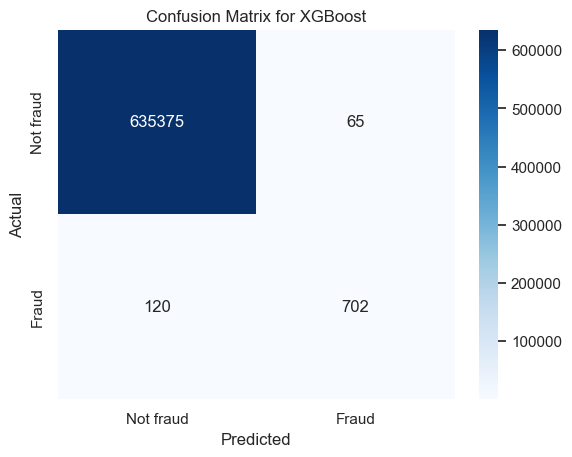

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

fig,ax = plt.subplots=(10,8)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not fraud','Fraud'],
            yticklabels=['Not fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for XGBoost')

In [49]:
# Probabilities for fraud class
y_proba_test = best_xgb.predict_proba(x_test)[:, 1]

In [50]:

# ROC curve + AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test, pos_label=1)
roc_auc = roc_auc_score(y_test, y_proba_test)
print('ROC-AUC score is ', roc_auc)


ROC-AUC score is  0.9991109624061094


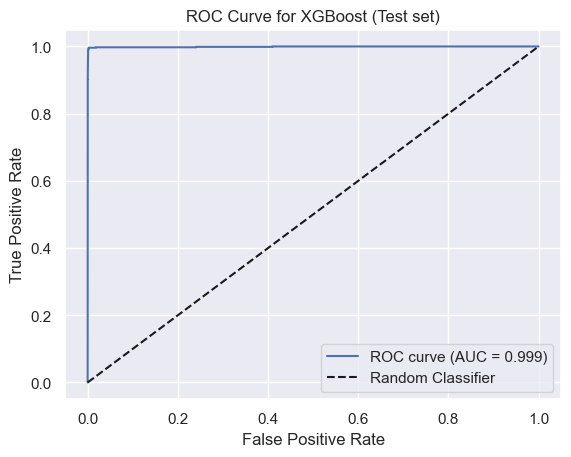

In [52]:
# Plot
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost (Test set)")
plt.legend(loc="lower right")
plt.show()

In [53]:
#Check for overfitting
y_proba_train = best_xgb.predict_proba(x_train)[:, 1]

auc_score_train=roc_auc_score(y_train, y_proba_train)
auc_score_test=roc_auc_score(y_test, y_proba_test)

print('AUC train',auc_score_train)
print('AUC test',auc_score_test)

AUC train 0.999906739922164
AUC test 0.9991109624061094


### Feature Importance

In [54]:
feat_imp=best_xgb.get_booster().get_score(importance_type="total_gain")

In [55]:
feature_importance=pd.DataFrame()
feature_importance["Variable"]=feat_imp.keys()
feature_importance["Importance value"]=feat_imp.values()
feature_importance["% Importance value"]=feature_importance["Importance value"]/feature_importance["Importance value"].sum()*100
feature_importance.sort_values(by=["Importance value"],ascending=False)

,Variable,Importance value,% Importance value
0,amount,1.382991e+06,29.370511
1,oldbalanceOrg,8.751531e+05,18.585580
3,senderMismatch,8.251828e+05,17.524364
9,type_TRANSFER,3.767227e+05,8.000440
4,receiverMismatch,3.694733e+05,7.846486
8,type_PAYMENT,3.446290e+05,7.318868
2,oldbalanceDest,2.425818e+05,5.151696
6,type_CASH_OUT,1.386086e+05,2.943624
5,isNight,1.087866e+05,2.310295
10,receiverType_Merchant,3.952048e+04,0.839294


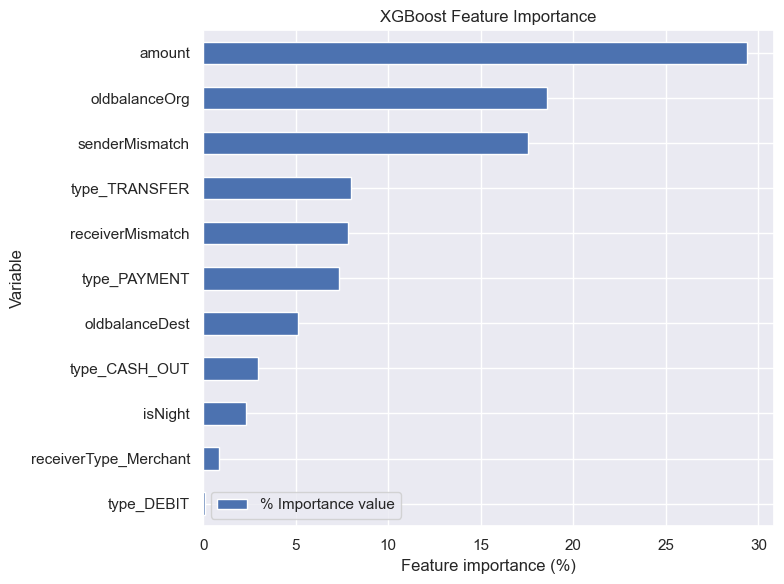

In [56]:
feature_importance.sort_values(
    "% Importance value",
    ascending=True
).plot(
    x="Variable",
    y="% Importance value",
    kind="barh",
    figsize=(8,6)
)

plt.xlabel("Feature importance (%)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()
